In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import gzip
import tensorflow as tf
import glob
import math
import skimage
import json
from matplotlib.patches import Rectangle

In [30]:
from softlearning.replay_pools.utils import get_replay_pool_from_variant

def get_grid_vals(env, n_samples):
    n_samples = 50
    obs_space = env.observation_space['state_observation']
    xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
    ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)
    xys = np.meshgrid(xs, ys)
    return np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2)), xys

def get_replay_pool(checkpoint, checkpoint_dir):
    from softlearning.replay_pools.utils import get_replay_pool_from_variant

    variant = checkpoint['variant']
    train_env = checkpoint['training_environment']
    replay_pool = get_replay_pool_from_variant(variant, train_env)

    replay_pool_path = os.path.join(checkpoint_dir, 'replay_pool.pkl')
    replay_pool.load_experience(replay_pool_path)
    return replay_pool

def plot_trajectories(checkpoint, checkpoint_dir, num_trajectories=10):
    replay_pool = get_replay_pool(checkpoint, checkpoint_dir)
    trajectories = replay_pool.last_n_batch(100 * num_trajectories)['observations']['state_observation'] \
                    .reshape(num_trajectories, 100, -1)
    for i in range(num_trajectories):
        plt.plot(trajectories[i,:,0], trajectories[i,:,1], color='w', linewidth=1)

## Specify the Experiment Directory

In [3]:
common_dir = '/home/kevinli/ray_results'
universe = 'gym'
domain = 'Point2D'
task = 'Maze-v0'

In [55]:
base_path = os.path.join(common_dir, universe, domain, task)
exps = sorted(list(glob.iglob(os.path.join(base_path, '*'))))
for i, exp in enumerate(exps):
    print(f'{i} \t {exp.replace(base_path, "")}')
    
exp_choice = int(input('\n Which experiment do you want to analyze? (ENTER A NUMBER) \t'))

exp_path = exps[exp_choice]
print('\n')
seeds = sorted(list(glob.iglob(os.path.join(exp_path, '*'))))
seeds = [seed for seed in seeds if os.path.isdir(seed)]
for i, seed in enumerate(seeds):
    print(f'{i} \t {seed.replace(exp_path, "")}')
    
# TODO: Extend to analyzing all seeds
seed_choice = int(input('\n Which seed do you want to analyze? (ENTER A NUMBER) \t'))

seed_path = seeds[seed_choice]

print('PATH:\n', seed_path)

0 	 /2020-05-27T15-58-21-test_ddl_maze
1 	 /2020-05-27T16-01-21-test_ddl_maze
2 	 /2020-05-27T16-02-07-test_ddl_maze
3 	 /2020-05-27T16-15-02-test_ddl_fixed
4 	 /2020-05-27T16-27-35-test_ddl_fixed
5 	 /2020-05-27T16-28-10-test_ddl_fixed
6 	 /2020-05-27T16-33-12-test_ddl_fixed
7 	 /2020-05-27T16-35-42-test_ddl_fixed
8 	 /2020-05-27T16-46-37-ddl_maze
9 	 /2020-05-27T17-48-05-test_ddl_maze
10 	 /2020-05-27T18-08-07-ddl_maze_count

 Which experiment do you want to analyze? (ENTER A NUMBER) 	10


0 	 /id=b10d1e58-seed=5665_2020-05-27_18-08-08m_k02ani
1 	 /id=b10db96c-seed=2276_2020-05-27_18-08-083tnxtdfm
2 	 /id=b10e2a3c-seed=8785_2020-05-27_18-08-082a4988sb
3 	 /id=b10e9e4a-seed=9604_2020-05-27_18-08-086u1x903v
4 	 /id=b111f374-seed=8761_2020-05-27_18-08-088ahet3e6
5 	 /id=b11364c0-seed=6292_2020-05-27_18-08-08k1txd1bx
6 	 /id=b11aefec-seed=2893_2020-05-27_18-08-09_vlnjkb9
7 	 /id=b11b69c2-seed=2745_2020-05-27_18-08-09a2k9l1i5
8 	 /id=b1222924-seed=3131_2020-05-27_20-21-51vik2awem
9 	 /id=

In [56]:
# Print hyperparameters

with open(os.path.join(seed_path, 'params.pkl'), 'rb') as f:
    params = pickle.load(f)

# print(json.dumps(params, indent=4))
hyperparams = {
    'use_count_reward': params['environment_params']['training']['kwargs'].get('use_count_reward', False),
    'discount': params['algorithm_params']['kwargs']['discount'],
    'ext_reward_coeff': params['algorithm_params']['kwargs']['ext_reward_coeff']
}
for name, value in hyperparams.items():
    print(f"{name}: {value}")

use_count_reward: True
discount: 0.99
ext_reward_coeff: 0.5


## Specify the Checkpoint

In [81]:
checkpoint_to_analyze = 200

In [82]:
checkpoint_dir = os.path.join(seed_path, f'checkpoint_{checkpoint_to_analyze}')
with open(os.path.join(checkpoint_dir, 'checkpoint.pkl'), 'rb') as f:
    checkpoint = pickle.load(f)

W0528 03:12:11.934751 140480156665664 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0528 03:12:12.635088 140480156665664 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0528 03:12:13.313105 140480156665664 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


## Load and Visualize Distance Function

In [59]:
checkpoint.keys()

dict_keys(['variant', 'training_environment', 'evaluation_environment', 'algorithm', 'policy_weights', 'rnd_networks', 'distance_estimator'])

In [83]:
# Load the distance function, goal, and environment, 
# then make distance predictions at points on a 50x50 grid
distance_fn = checkpoint['distance_estimator']
train_env = checkpoint['training_environment']
target_pos = train_env.unwrapped._get_obs()['state_desired_goal']

n_samples = 50
grid_vals, _ = get_grid_vals(train_env, n_samples)
goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
dists = distance_fn.predict([grid_vals, goal_vals])

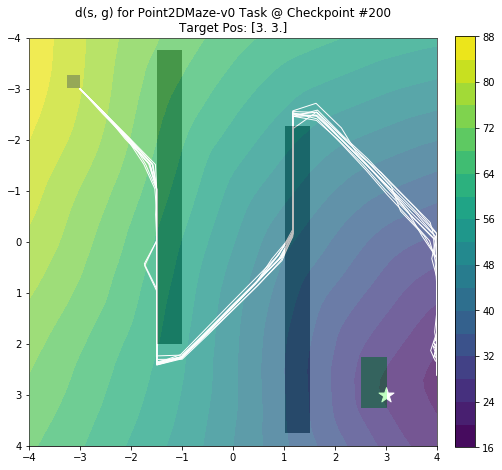

In [84]:
# Plot a contour map of distance predictions across the environment
plt.figure(figsize=(8, 8))
from matplotlib.patches import Rectangle

plt.imshow(train_env.render('rgb_array', width=32, height=32),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

grid_vals, xys = get_grid_vals(train_env, 50)
plt.gca().invert_yaxis()
plt.contourf(xys[0], xys[1], dists.reshape(xys[0].shape), levels=20, zorder=1)
plt.colorbar(fraction=0.046, pad=0.04)

plot_trajectories(checkpoint, checkpoint_dir)

if task == 'BoxWall-v1':
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((-2, -2), 4, 4,
                          alpha=1, fill=None, linewidth=4))
    
plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

plt.title(f'd(s, g) for {domain + task} Task @ Checkpoint #{checkpoint_to_analyze}\n'
          + f'Target Pos: {target_pos}')
plt.show()

## Plot Evolution of Distance Function over Many Checkpoints

In [16]:
def plot_distance_to_goal(distance_fn, train_env, n_samples=50):
    grid_vals, xys = get_grid_vals(train_env, n_samples)
    dists = distance_fn.predict([grid_vals, goal_vals])
    
#     plt.figure(figsize=(8, 8))
    from matplotlib.patches import Rectangle

    plt.imshow(train_env.render('rgb_array', width=32, height=32),
               extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

    plt.gca().invert_yaxis()
    plt.contourf(xys[0], xys[1], dists.reshape(xys[0].shape), levels=20, zorder=1)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

In [17]:
def plot_grid(imgs, labels=None):
    n_images = len(imgs)
    n_columns = np.sqrt(n_images)
    n_rows = np.ceil(n_images / n_columns) + 1
    plt.figure(figsize=(5 * n_columns, 5 * n_rows))
    for i, img in enumerate(imgs):
        plt.subplot(n_rows, n_columns, i+1)
        plt.axis('off')
        plt.imshow(img)
        if labels is not None:
            plt.title(labels[i], fontsize=20)
    plt.show()

In [85]:
checkpoint_paths = list(glob.iglob(os.path.join(seed_path, 'checkpoint_*')))
# Sort by the checkpoint number at the end
checkpoint_paths = sorted(checkpoint_paths, key=lambda s: int(s.split("_")[-1]))

W0528 03:12:44.032900 140480156665664 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0528 03:12:44.787372 140480156665664 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0528 03:12:45.604826 140480156665664 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0528 03:12:46.906095 140480156665664 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0528 03:12:47.706672 140480156665664 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0528 03:12:48.483200 140480156665664 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0528 03:12:49.973229 140480156665664 hdf5_format.py:171] No training 

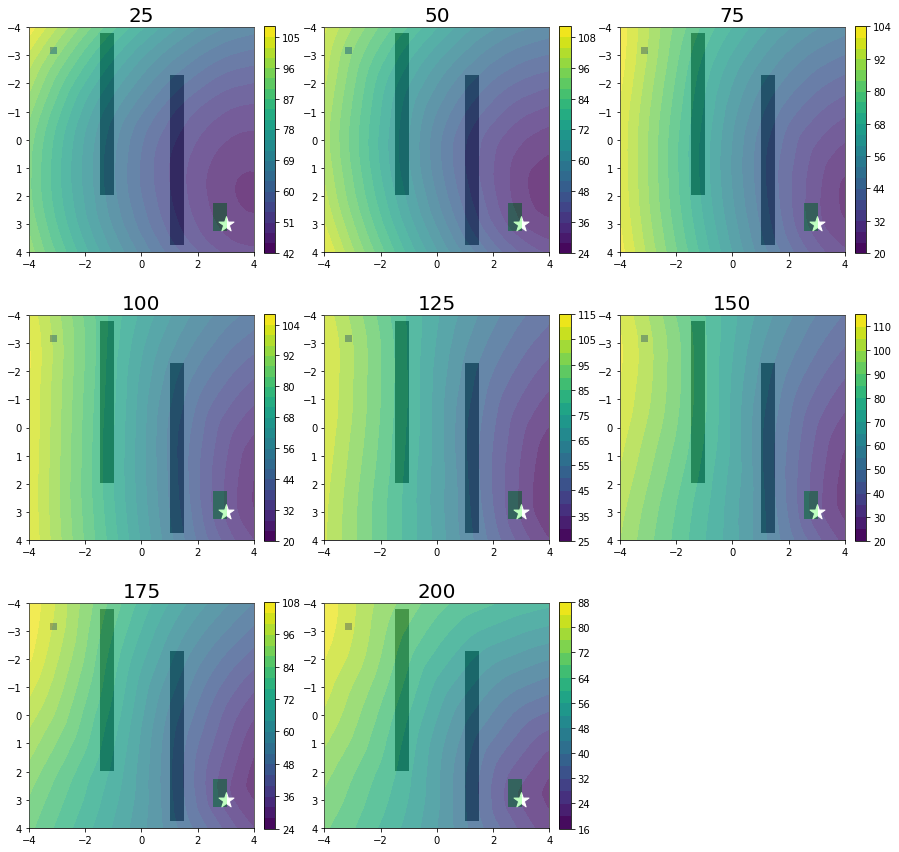

In [86]:
n_plots = len(checkpoint_paths)
n_columns = int(np.sqrt(n_plots) + 1)
n_rows = np.ceil(n_plots / n_columns)
plt.figure(figsize=(5 * n_columns, 5 * n_rows))

imgs = []
for i, path in enumerate(checkpoint_paths):
    with open(os.path.join(path, 'checkpoint.pkl'), 'rb') as f:
        checkpoint = pickle.load(f)
    distance_fn = checkpoint['distance_estimator']
    train_env = checkpoint['training_environment']
    plt.subplot(n_rows, n_columns, i+1, aspect=1)
    plot_distance_to_goal(distance_fn, train_env)
    plt.title(int(path.split("_")[-1]), fontsize=20)
    
plt.show()

## Generate GIF of Distance over Time

W0528 03:05:55.173480 140480156665664 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0528 03:05:55.572438 140480156665664 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0528 03:05:55.997426 140480156665664 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
/home/kevinli/anaconda3/envs/softlearning/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()
W0528 03:05:56.942797 140480156665664 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0528 03:05:57.338908 140480156665664 hdf5_format.py:171] No training configuration found in save file: the model was *not

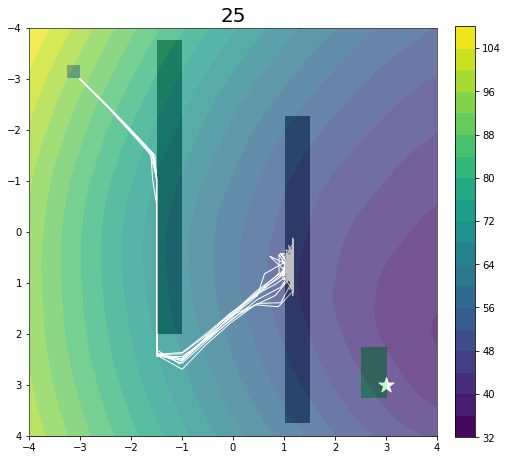

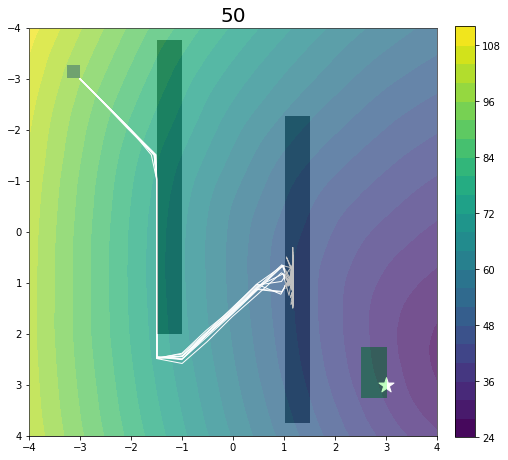

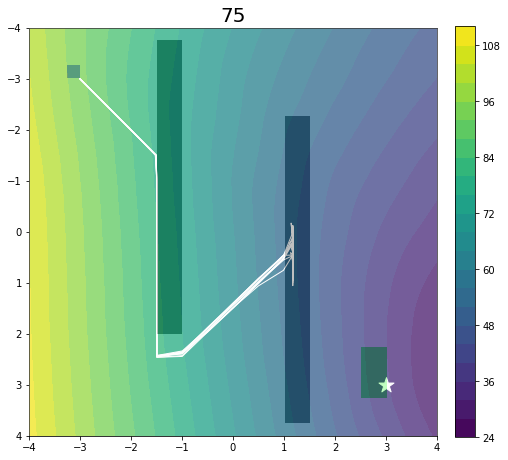

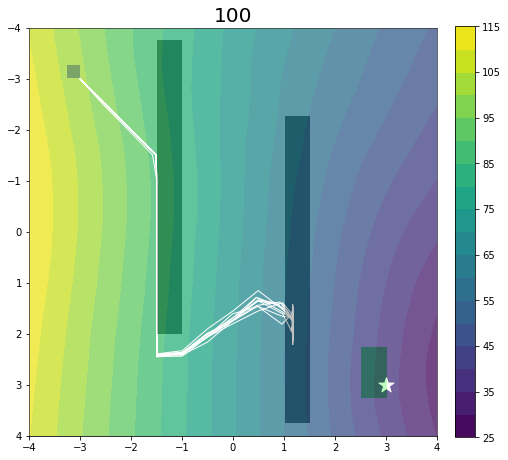

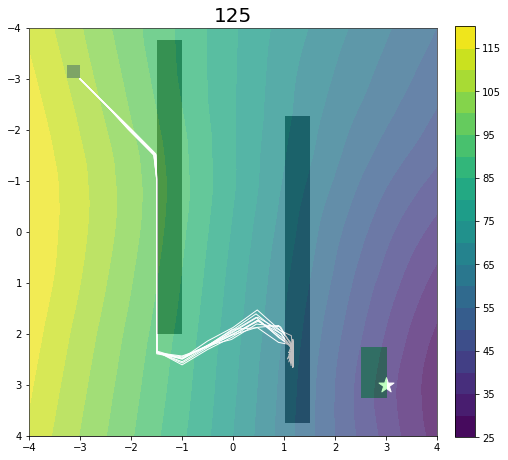

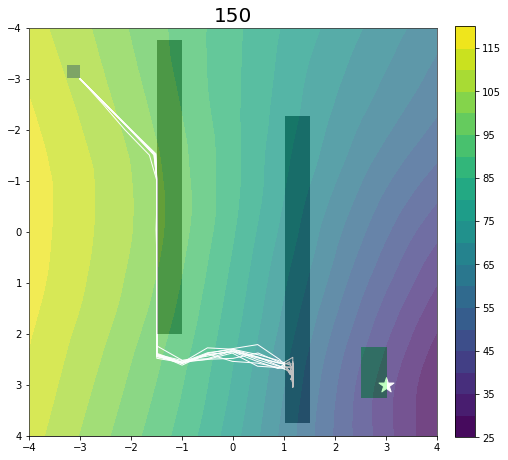

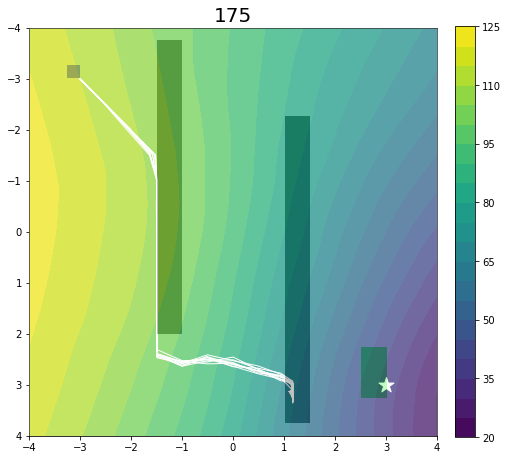

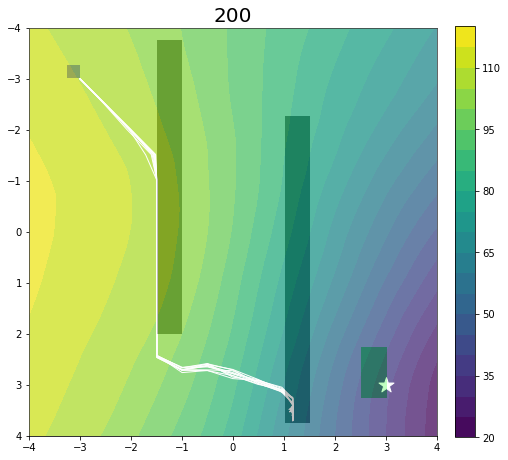

In [32]:
checkpoint_paths = list(glob.iglob(os.path.join(seed_path, 'checkpoint_*')))
# Sort by the checkpoint number at the end
checkpoint_paths = sorted(checkpoint_paths, key=lambda s: int(s.split("_")[-1]))

imgs = []
for i, path in enumerate(checkpoint_paths):
    fig = plt.figure(figsize=(8, 8))
    with open(os.path.join(path, 'checkpoint.pkl'), 'rb') as f:
        checkpoint = pickle.load(f)
    distance_fn = checkpoint['distance_estimator']
    train_env = checkpoint['training_environment']
    plot_distance_to_goal(distance_fn, train_env)
    plt.title(int(path.split("_")[-1]), fontsize=20)
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    imgs.append(data)

In [14]:
import imageio
imageio.mimsave('./test.gif', imgs, duration=1.0)

## Plot Ground Truth Rewards

In [87]:
feed_dict = {
    'state_achieved_goal': grid_vals,
    'state_desired_goal': np.full(grid_vals.shape, fill_value=2)
}
train_env.unwrapped.reward_type = 'sparse'
gtr = train_env.unwrapped.compute_rewards(None, feed_dict)
plt.figure(figsize=(8, 8))

from matplotlib.patches import Rectangle

plt.gca().invert_yaxis()

plt.contourf(xys[0], xys[1], gtr.reshape(xys[0].shape))
plt.colorbar(fraction=0.046, pad=0.04)

plt.scatter([2], [2], color='r')

if task == 'BoxWall-v1':
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((-2, -2), 4, 4,
                          alpha=1, fill=None, linewidth=4))

plt.title(f'Ground Truth Reward for {domain + task} Task @ Checkpoint #{checkpoint_to_analyze}')

plt.scatter(*target_pos, marker='*', s=250, color='white')
plt.show()

KeyError: 'discrete_observation'

## Qs Visualization

In [88]:
# Load the checkpoint
checkpoint_to_analyze = 200
checkpoint_dir = os.path.join(seed_path, f'checkpoint_{checkpoint_to_analyze}')

with open(os.path.join(checkpoint_dir, 'checkpoint.pkl'), 'rb') as f:
    checkpoint = pickle.load(f)

W0528 03:13:16.448507 140480156665664 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0528 03:13:17.449389 140480156665664 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0528 03:13:18.411731 140480156665664 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [89]:
variant = checkpoint['variant']
env = checkpoint['training_environment']
target_pos = env.unwrapped._get_obs()['state_desired_goal']

In [90]:
from softlearning.value_functions.utils import get_Q_function_from_variant

In [91]:
# Initialize a double value function and load weights from the checkpoint file
Qs = get_Q_function_from_variant(variant, env)

for i, Q in enumerate(Qs):
    weights_path = os.path.join(checkpoint_dir, f'Qs_{i}')
    Q.load_weights(weights_path)

In [92]:
# Sample n actions from the full action space.
# We will plot the worst-case Q value over all of these actions (?)
n_action_samples = 20
sample_actions = np.vstack([env.action_space.sample() for _ in range(n_action_samples)])

In [78]:
# Create a 50x50 grid of coordinates to evaluate
n_samples = 50
grid_vals, xys = get_grid_vals(env, n_samples)

In [79]:
# Compute Q values at each coordinate
value_estimates = []
for pos in grid_vals:
    value_estimates.append(
        np.min([Q.predict([sample_actions,
                        np.repeat(pos, n_action_samples).reshape((n_action_samples, -1))])
             for Q in Qs])
    )

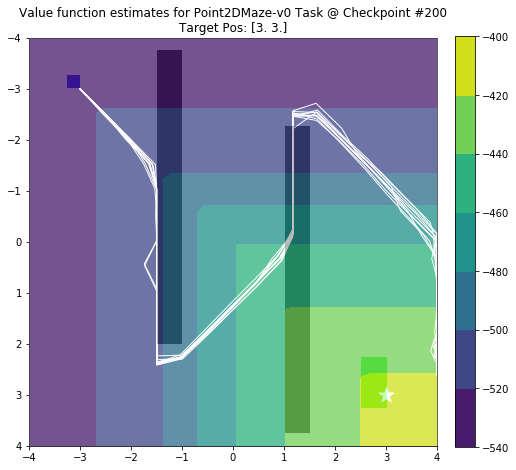

In [80]:
# Plot a contour map of value estimates
plt.figure(figsize=(8, 8))
from matplotlib.patches import Rectangle

plt.imshow(train_env.render('rgb_array', width=32, height=32),
               extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)
plt.gca().invert_yaxis()
plt.contourf(xys[0], xys[1], np.array(value_estimates).reshape(xys[0].shape))
plt.colorbar(fraction=0.046, pad=0.04)

if task == 'BoxWall-v1':
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((-2, -2), 4, 4,
                          alpha=1, fill=None, linewidth=4))
    
plot_trajectories(checkpoint, checkpoint_dir)

plt.scatter(*target_pos, marker='*', s=250, color='white')
plt.title(f'Value function estimates for {domain + task} Task @ Checkpoint #{checkpoint_to_analyze}\n'
          + f'Target Pos: {target_pos}')
plt.show()

In [25]:
np.repeat(grid_vals[0], n_action_samples).reshape((n_action_samples, -1))

array([[-4., -4.],
       [-4., -4.],
       [-4., -4.],
       [-4., -4.],
       [-4., -4.],
       [-4., -4.],
       [-4., -4.],
       [-4., -4.],
       [-4., -4.],
       [-4., -4.],
       [-4., -4.],
       [-4., -4.],
       [-4., -4.],
       [-4., -4.],
       [-4., -4.],
       [-4., -4.],
       [-4., -4.],
       [-4., -4.],
       [-4., -4.],
       [-4., -4.]])

## Visualize Embedding Function

In [ ]:
embedding_fn = checkpoint['distance_estimator']
train_env = checkpoint['training_environment']
target_pos = train_env.unwrapped._get_obs()['state_desired_goal']

n_samples = 50
grid_vals = get_grid_vals(train_env, n_samples)
goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
dists = np.linalg.norm(embedding_fn.predict(goal_vals) - embedding_fn.predict(grid_vals), axis=-1)

In [ ]:
plt.figure(figsize=(8, 8))
from matplotlib.patches import Rectangle

plt.imshow(train_env.render('rgb_array', width=256, height=256),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

plt.gca().invert_yaxis()
plt.contourf(xys[0], xys[1], dists.reshape(xys[0].shape), levels=300, zorder=1)
plt.colorbar(fraction=0.046, pad=0.04)
    
plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

plt.title(f'|phi(g) - phi(s)| for {domain + task} Task @ Checkpoint #{checkpoint_to_analyze}\n'
          + f'Target Pos: {target_pos}')
plt.show()

In [ ]:
embedded_goal = embedding_fn.predict(target_pos[None])

In [ ]:
radii = np.arange(0.5, 9, 0.5)
pts_by_radius = []
for r in radii:
    embedded_pts = []
    for theta in np.arange(0, 2 * np.pi + np.pi / 30, np.pi / 30):
        dx = r * np.cos(theta)
        dy = r * np.sin(theta)
        pt = target_pos + np.array([dx, dy])
        x, y = pt
        if -4 <= x and x <= 4 and -4 <= y and y <= 4:
            embedded_pt = embedding_fn.predict(pt[None])
            embedded_pts.append(embedded_pt)
    pts_by_radius.append(np.vstack(embedded_pts))

In [ ]:
border_pts = []
border_range = np.arange(-4 + 0.1, 4 - 0.1, 0.1).reshape(-1, 1)
border_pts.append(np.hstack(
    (np.ones(border_range.shape) * (4 - 0.1), border_range)
))
border_pts.append(np.hstack(
    (np.ones(border_range.shape) * (-4 + 0.1), border_range)
))
border_pts.append(np.hstack(
    (border_range, np.ones(border_range.shape) * (-4 + 0.1))
))
border_pts.append(np.hstack(
    (border_range, np.ones(border_range.shape) * (4 - 0.1))
))
border_pts = np.vstack(border_pts)

In [ ]:
embedded_border = embedding_fn.predict(border_pts)

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(embedded_goal[0][0], embedded_goal[0][1])
for pts in pts_by_radius:
    plt.plot(pts[:, 0], pts[:, 1])
plt.legend(radii)
plt.title('Trajectory in Embedding Space')

plt.plot(embedded_trajectory[:, 0], embedded_trajectory[:, 1], 'black')
# plt.quiver(embedded_trajectory[:-1, 0],
#            embedded_trajectory[:-1, 1],
#            embedded_actions[:, 0],
#            embedded_actions[:, 1],
#            color='black',
#            alpha=0.5,
#            linewidth=2,
#            headwidth=4)

In [ ]:
plt.figure(figsize=(8, 8))

plt.imshow(train_env.render('rgb_array', width=256, height=256),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)
plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

trajectory = sample_trajectory['observations']['state_observation']
next_obs = sample_trajectory['next_observations']['state_observation']
actions = next_obs - trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1], 'black')

radii = np.arange(0.5, 9, 0.5)
circles = []
for r in radii:
    pts = []
    for theta in np.arange(0, 2 * np.pi + np.pi / 30, np.pi / 30):
        dx = r * np.cos(theta)
        dy = r * np.sin(theta)
        pt = target_pos + np.array([dx, dy])
        x, y = pt
        if -4 <= x and x <= 4 and -4 <= y and y <= 4:
            pts.append(np.array([[x, y]]))
    circles.append(np.vstack(pts))

for circle in circles:
    plt.plot(circle[:, 0], circle[:, 1])
    
plt.gca().invert_yaxis()

plt.title(f'|phi(g) - phi(s)| for {domain + task} Task @ Checkpoint #{checkpoint_to_analyze}\n'
          + f'Target Pos: {target_pos}')
plt.show()

In [ ]:
checkpoint.keys()

In [ ]:
from softlearning.replay_pools.utils import get_replay_pool_from_variant

variant = checkpoint['variant']
train_env = checkpoint['training_environment']
replay_pool = get_replay_pool_from_variant(variant, train_env)

replay_pool_path = os.path.join(checkpoint_dir, 'replay_pool.pkl')
replay_pool.load_experience(replay_pool_path)

In [ ]:
sample_trajectory = replay_pool.last_n_batch(100)

In [ ]:
embedded_trajectory = embedding_fn.predict(sample_trajectory['observations']['state_observation'])
embedded_actions = embedded_trajectory[1:, :] - embedded_trajectory[:-1, :]